hello 

In [112]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from numpy.fft import fft
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp 
from scipy import signal
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from scipy.signal import butter,filtfilt,freqz
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import tsfel

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Reading our csv files

In [73]:
dfB = pd.read_csv("Data-Table 1.csv",thousands=',')
dfW = pd.read_csv("london_weather.csv",parse_dates=["date"])

Getting general information on our files like the shape, coloumn names, and types

In [74]:
print(dfB.shape)
print(dfW.shape)

(4538, 18)
(15341, 10)


In [75]:
print(dfB.columns)
print(dfW.columns)

Index(['Day', 'Number of Bicycle Hires', 'Unnamed: 2', 'Month',
       'Number of Bicycle Hires.1', 'Unnamed: 5', 'Year',
       'Number of Bicycle Hires.2', 'Unnamed: 8', 'Month.1',
       'Average Hire Time (mins)', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'],
      dtype='object')
Index(['date', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth'],
      dtype='object')


In [76]:
print(dfB.info())
print(dfW.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4538 entries, 0 to 4537
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Day                        4538 non-null   object 
 1   Number of Bicycle Hires    4538 non-null   int64  
 2   Unnamed: 2                 0 non-null      float64
 3   Month                      150 non-null    object 
 4   Number of Bicycle Hires.1  150 non-null    float64
 5   Unnamed: 5                 0 non-null      float64
 6   Year                       142 non-null    object 
 7   Number of Bicycle Hires.2  149 non-null    object 
 8   Unnamed: 8                 0 non-null      float64
 9   Month.1                    150 non-null    object 
 10  Average Hire Time (mins)   150 non-null    float64
 11  Unnamed: 11                0 non-null      float64
 12  Unnamed: 12                1 non-null      object 
 13  Unnamed: 13                1 non-null      objec

In [77]:
print(dfB.describe())
print(dfW.describe())

       Number of Bicycle Hires  Unnamed: 2  Number of Bicycle Hires.1  \
count              4538.000000         0.0               1.500000e+02   
mean              26753.463861         NaN               7.565836e+05   
std                9870.859958         NaN               2.955487e+05   
min                   0.000000         NaN               0.000000e+00   
25%               19686.500000         NaN               5.870165e+05   
50%               26529.500000         NaN               7.492045e+05   
75%               33987.250000         NaN               9.976160e+05   
max               73094.000000         NaN               1.253102e+06   

       Unnamed: 5  Unnamed: 8  Average Hire Time (mins)  Unnamed: 11  \
count         0.0         0.0                150.000000          0.0   
mean          NaN         NaN                 19.346667          NaN   
std           NaN         NaN                  3.485322          NaN   
min           NaN         NaN                 14.00000

Dropping unnessiscary colunms from the bike data set

In [78]:
dfB = dfB.drop(columns = ['Unnamed: 2','Month','Number of Bicycle Hires.1', 'Unnamed: 5', 'Year',
       'Number of Bicycle Hires.2', 'Unnamed: 8', 'Month.1',
       'Average Hire Time (mins)', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'])
       




Converting the timestamps to dates and formatting the dates

In [79]:
dfB = dfB.convert_dtypes()
dfB["Day"] = pd.to_datetime(dfB["Day"])
dfW = dfW.convert_dtypes()
dfW["date"] = pd.to_datetime(dfW["date"])

dfB["Day"] = dfB["Day"].dt.strftime('%Y-%m-%d')
dfW["date"] = dfW["date"].dt.strftime('%Y-%m-%d')

Splicing the data sets so they line up with each other

In [80]:
print(dfW['date'][0])
print(dfW['date'][-1:])
print(dfB['Day'][0])
print(dfB['Day'][-1:])

dfW = dfW[~(dfW['date'] < '2010-07-30')]
dfB = dfB[~(dfB['Day'] > '2020-12-31')]

1979-01-01
15340    2020-12-31
Name: date, dtype: object
2010-07-30
4537    2022-12-31
Name: Day, dtype: object


Setting the index to the dates coloumn

In [81]:
dfW["date"] = pd.to_datetime(dfW["date"])
dfB["Day"] = pd.to_datetime(dfB["Day"])
dfB = dfB.set_index("Day")
dfW = dfW.set_index("date")

In [82]:
dfW.info()
dfB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       3805 non-null   Int64  
 1   sunshine          3808 non-null   Float64
 2   global_radiation  3802 non-null   Int64  
 3   max_temp          3802 non-null   Float64
 4   mean_temp         3801 non-null   Float64
 5   min_temp          3806 non-null   Float64
 6   precipitation     3802 non-null   Float64
 7   pressure          3808 non-null   Int64  
 8   snow_depth        3171 non-null   Int64  
dtypes: Float64(5), Int64(4)
memory usage: 331.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Number of Bicycle Hires  3808 non-null   Int64
dtypes: Int64(1)
memory usa

a graph of the snow depth

<Axes: xlabel='date', ylabel='snow_depth'>

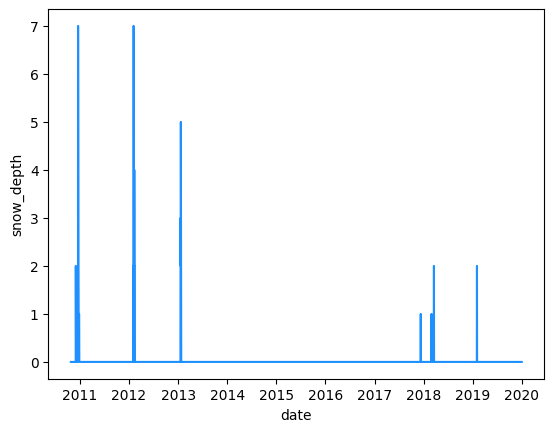

In [83]:
sns.lineplot(x=dfW.index, y=dfW["snow_depth"],  color='dodgerblue')

a graph of the missing values in the weather data sets

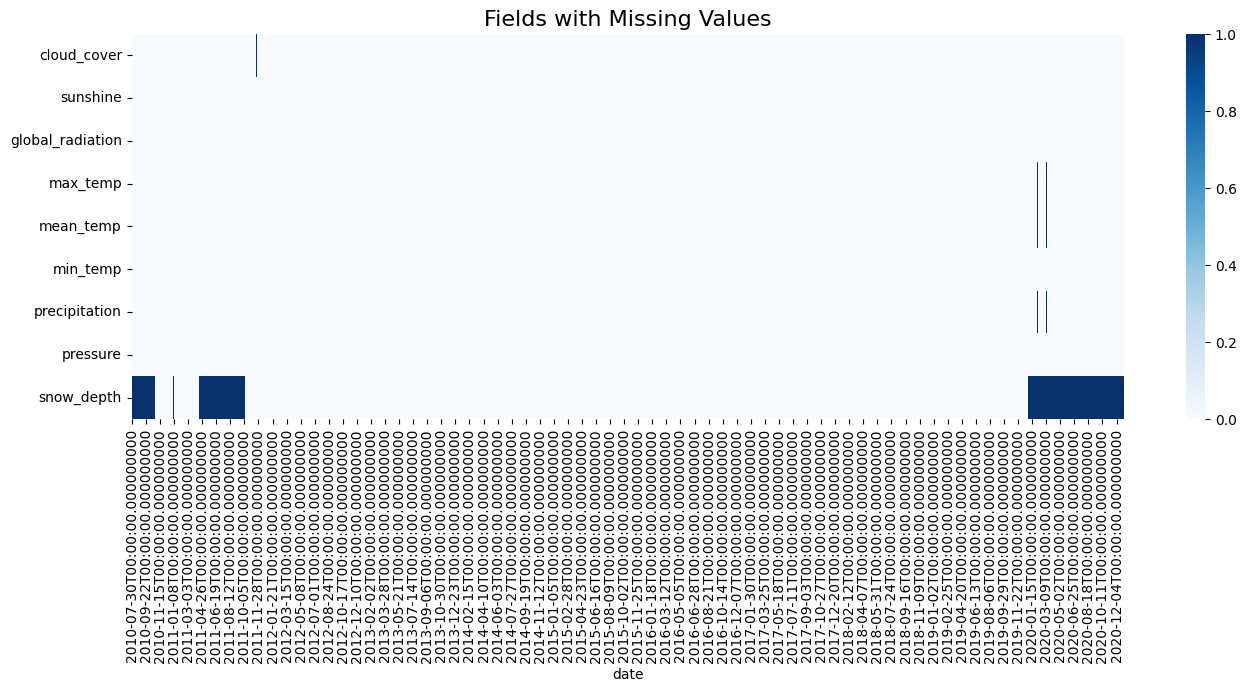

In [84]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(dfW.isna().transpose(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
plt.show()

Getting the exact amount of nan values 

In [85]:
dfW.isna().sum()


cloud_cover           3
sunshine              0
global_radiation      6
max_temp              6
mean_temp             7
min_temp              2
precipitation         6
pressure              0
snow_depth          637
dtype: int64

Converting the types to floats

In [86]:
dfW["cloud_cover"] = dfW["cloud_cover"].values.astype(float)
dfW["global_radiation"] = dfW["global_radiation"].values.astype(float)
dfW["max_temp"] = dfW["max_temp"].values.astype(float)
dfW["mean_temp"] = dfW["mean_temp"].values.astype(float)
dfW["min_temp"] = dfW["min_temp"].values.astype(float)
dfW["precipitation"] = dfW["precipitation"].values.astype(float)
dfW["snow_depth"] = dfW["snow_depth"].values.astype(float)



dfW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       3805 non-null   float64
 1   sunshine          3808 non-null   Float64
 2   global_radiation  3802 non-null   float64
 3   max_temp          3802 non-null   float64
 4   mean_temp         3801 non-null   float64
 5   min_temp          3806 non-null   float64
 6   precipitation     3802 non-null   float64
 7   pressure          3808 non-null   Int64  
 8   snow_depth        3171 non-null   float64
dtypes: Float64(1), Int64(1), float64(7)
memory usage: 434.0 KB


Plotting a graph to show the interpolation on snow depth

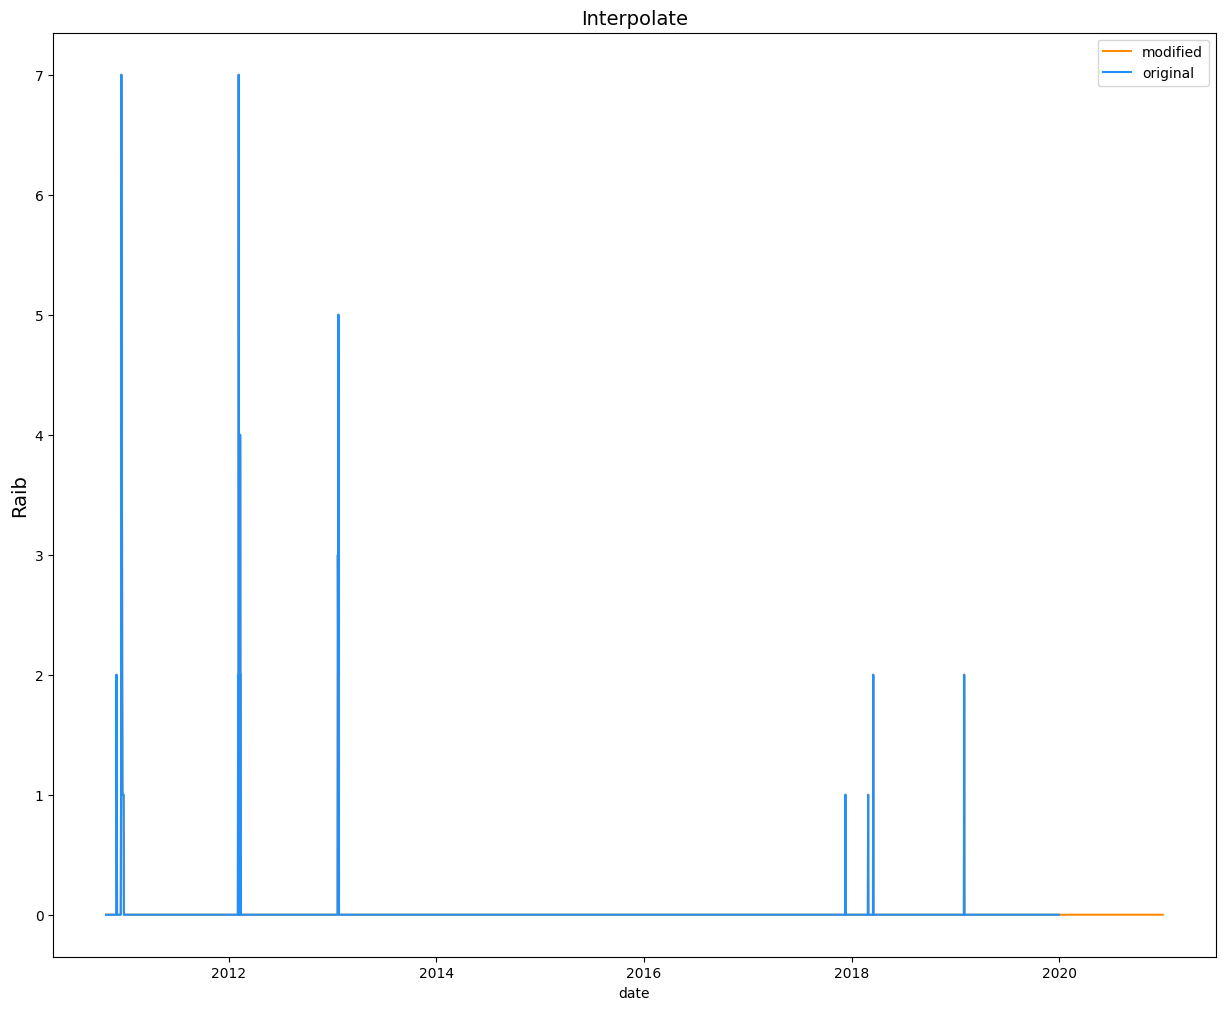

In [87]:
data = dfW
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
sns.lineplot(x=data.index, y=data.snow_depth.interpolate(),color='darkorange', label = 'modified')
sns.lineplot(x=data.index, y=data.snow_depth.fillna(np.inf),  color='dodgerblue', label = 'original')
ax.set_title(f'Interpolate', fontsize=14)
ax.set_ylabel(ylabel='Raib', fontsize=14)
plt.show()

interpolating each colounm with nan values

In [88]:
dfW['cloud_cover'] = dfW['cloud_cover'].interpolate()
dfW['global_radiation'] = dfW['global_radiation'].interpolate()
dfW['max_temp'] = dfW['max_temp'].interpolate()
dfW['mean_temp'] = dfW['mean_temp'].interpolate()
dfW['min_temp'] = dfW['min_temp'].interpolate()
dfW['precipitation'] = dfW['precipitation'].interpolate()
dfW['snow_depth'] = dfW['snow_depth'].interpolate()
dfW['snow_depth'] = dfW['snow_depth'].bfill()


creating a graph with all the weather value coloums

In [89]:
fig, ax = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(16,12))

ax[0][0].bar(dfW.index, dfW.cloud_cover, width=5, color='dodgerblue')
ax[0][0].set_title('Cloud Cover', fontsize=14)
ax[1][0].bar(dfW.index, dfW.global_radiation, width=5, color='dodgerblue')
ax[1][0].set_title('Global Radiation', fontsize=14)
ax[2][0].bar(dfW.index, dfW.max_temp, width=5, color='dodgerblue')
ax[2][0].set_title('Max Temp', fontsize=14)
ax[0][1].bar(dfW.index, dfW.mean_temp, width=5, color='dodgerblue')
ax[0][1].set_title('Mean Temp', fontsize=14)
ax[1][1].bar(dfW.index, dfW.min_temp, width=5, color='dodgerblue')
ax[1][1].set_title('Min Temp', fontsize=14)
ax[2][1].bar(dfW.index, dfW.precipitation, width=5, color='dodgerblue')
ax[2][1].set_title('Precipation', fontsize=14)
ax[0][2].bar(dfW.index, dfW.snow_depth, width=5, color='dodgerblue')
ax[0][2].set_title('Snow Depth', fontsize=14)
ax[1][2].bar(dfW.index, dfW.sunshine, width=5, color='dodgerblue')
ax[1][2].set_title('Sunshine', fontsize=14)
ax[2][2].bar(dfW.index, dfW.pressure, width=5, color='dodgerblue')
ax[2][2].set_title('Pressure', fontsize=14)

plt.show()

KeyboardInterrupt: 

<Axes: xlabel='Day', ylabel='Number of Bicycle Hires'>

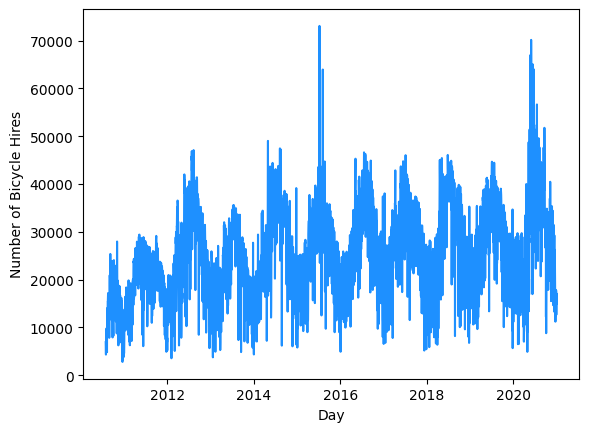

In [90]:
sns.lineplot(x=dfB.index, y=dfB["Number of Bicycle Hires"],  color='dodgerblue')

Combining the two datasets

In [91]:
frames = [dfW, dfB['Number of Bicycle Hires']]
df = pd.concat(frames, axis=1)
#kkx = df.copy()

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cloud_cover              3808 non-null   float64
 1   sunshine                 3808 non-null   Float64
 2   global_radiation         3808 non-null   float64
 3   max_temp                 3808 non-null   float64
 4   mean_temp                3808 non-null   float64
 5   min_temp                 3808 non-null   float64
 6   precipitation            3808 non-null   float64
 7   pressure                 3808 non-null   Int64  
 8   snow_depth               3808 non-null   float64
 9   Number of Bicycle Hires  3808 non-null   Int64  
dtypes: Float64(1), Int64(2), float64(7)
memory usage: 467.4 KB


In [ ]:
#df_down = df.resample("2D").mean()
#df_down.info()

Creating a correlation graph

<Axes: >

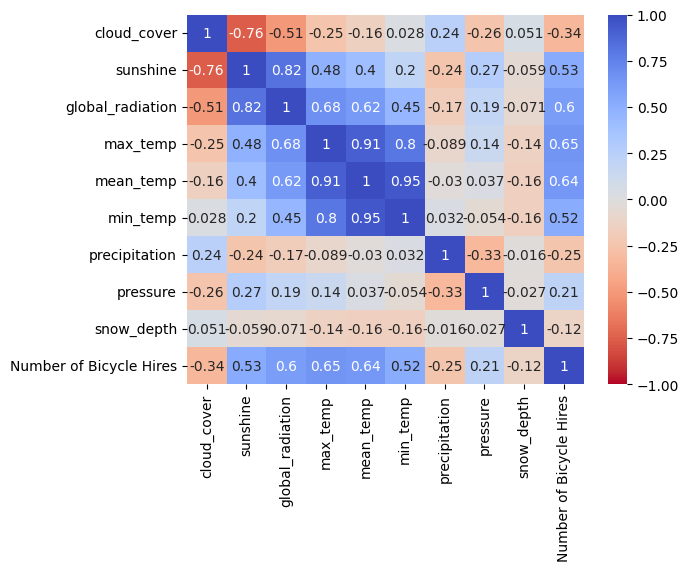

In [93]:
corrmat = df.corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')

Normalising the data

In [94]:
scaler = MinMaxScaler()
# fit and transform the data
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_norm

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,Number of Bicycle Hires
0,0.666667,0.19375,0.378173,0.672634,0.662614,0.684543,0.042636,0.553928,0.0,0.058766
1,0.555556,0.29375,0.446701,0.641944,0.765957,0.832808,0.000000,0.512650,0.0,0.039812
2,0.777778,0.01875,0.205584,0.629156,0.711246,0.757098,0.000000,0.533955,0.0,0.021883
3,0.777778,0.12500,0.319797,0.634271,0.717325,0.788644,0.000000,0.581891,0.0,0.055140
4,0.555556,0.24375,0.408629,0.544757,0.668693,0.678233,0.000000,0.567244,0.0,0.073966
...,...,...,...,...,...,...,...,...,...,...
3803,0.111111,0.05625,0.060914,0.222506,0.352584,0.536278,0.038760,0.091877,0.0,0.212740
3804,0.777778,0.23125,0.076142,0.122762,0.158055,0.255521,0.003876,0.007989,0.0,0.140296
3805,0.777778,0.00000,0.032995,0.135550,0.203647,0.331230,0.000000,0.202397,0.0,0.169231
3806,0.666667,0.02500,0.035533,0.173913,0.206687,0.293375,0.000000,0.384820,0.0,0.203540


Noise removal

In [95]:
T = 86400         
fs = 0.00001       
cutoff = 0.000001      
nyq = 0.5 * fs  
order = 2       
n = int(T * fs) 

In [96]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [101]:
# Filter the data, and plot both the original and filtered signals.
df_noise = butter_lowpass_filter(df, cutoff, fs, order)
fig = go.Figure()
fig.add_trace(go.Scatter(
            y = data,
            line =  dict(shape =  'spline' ),
            name = 'signal with noise'
            ))
fig.add_trace(go.Scatter(
            y = df_noise,
            line =  dict(shape =  'spline' ),
            name = 'filtered signal'
            ))
fig.show()

Initalising the k-fold

In [98]:
kf = KFold(n_splits=10)
kf.get_n_splits(df)
print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


Spliting the colounms into features and targets

In [131]:
df_noise = pd.DataFrame(df_noise)

In [103]:
features = df.iloc[:, [0,1,2,3,4,5,6,7,8]].values
targets = df.iloc[:, 9].values
features_norm = df_norm.iloc[:, [0,1,2,3,4,5,6,7,8]].values
targets_norm = df_norm.iloc[:, 9].values
features_noise = df_noise.iloc[:, [0,1,2,3,4,5,6,7,8]].values
targets_noise = df_noise.iloc[:, 9].values

print(features)


[[6.0 3.1 157.0 ... 2.2 101470 0.0]
 [5.0 4.7 184.0 ... 0.0 101160 0.0]
 [7.0 0.3 89.0 ... 0.0 101320 0.0]
 ...
 [7.0 0.0 21.0 ... 0.0 98830 0.0]
 [6.0 0.4 22.0 ... 0.0 100200 0.0]
 [7.0 1.3 34.0 ... 0.0 100500 0.0]]


Testing the linear regression model

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(df)):
    X_train, X_test, Y_train, Y_test = features[train_index], features[test_index], targets[train_index], targets[test_index]
    model = LinearRegression()
    model.fit(X_train, Y_train)
    print(model.score(X_test, Y_test))

-2.06757569385603
0.5277284472016859
0.4549687418509011
0.7121262984784746
0.6137127572629197
0.6157579305877448
0.4783841152049094
0.6644247504834355
0.466359815197142
0.42239408015860946


Testing the linear regression model with the normalised data

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(df_norm)):
    X_train, X_test, Y_train, Y_test = features_norm[train_index], features_norm[test_index], targets_norm[train_index], targets_norm[test_index]
    model = LinearRegression()
    model.fit(X_train, Y_train)
    print(model.score(X_test, Y_test))

-2.0675756938560115
0.527728447201669
0.4549687418509244
0.7121262984784575
0.6137127572629146
0.615757930587745
0.4783841152049193
0.664424750483433
0.4663598151971482
0.42239408015860935


In [104]:
for i, (train_index, test_index) in enumerate(kf.split(df_norm)):
    X_train, X_test, Y_train, Y_test = features_noise[train_index], features_noise[test_index], targets_noise[train_index], targets_noise[test_index]
    model = LinearRegression()
    model.fit(X_train, Y_train)
    print(model.score(X_test, Y_test))

0.9999999999999964
0.9999999999999987
0.999999999999999
0.9999999999999998
0.9999999999999996
0.9999999999999997
0.9999999999999996
0.9999999999999997
0.9999999999999996
0.9999999999999999


In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(df)):
    X_train, X_test, Y_train, Y_test = features[train_index], features[test_index], targets[train_index], targets[test_index]
    model = DecisionTreeRegressor(random_state=1)
    model.fit(X_train, Y_train)
    print(model.score(X_test, Y_test))


-3.281529894084212
0.04098900917494863
-0.1262327909662213
0.28764856907562775
0.03865215182200632
-0.10219926252821998
-0.24083793740005754
0.2576901802574425
-0.14934586603370192
0.02860759883944375


In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(df_norm)):
    X_train, X_test, Y_train, Y_test = features_norm[train_index], features_norm[test_index], targets_norm[train_index], targets_norm[test_index]
    model = DecisionTreeRegressor(random_state=1)
    model.fit(X_train, Y_train)
    print(model.score(X_test, Y_test))

-3.2112431927199436
0.09351367662926136
-0.11411710549075704
0.2784651487704153
0.10890792456631015
-0.09168281128854949
-0.2749187087999201
0.26359739678539373
-0.13103246050780393
0.11647022210518432


In [105]:
for i, (train_index, test_index) in enumerate(kf.split(df)):
    X_train, X_test, Y_train, Y_test = features_noise[train_index], features_noise[test_index], targets_noise[train_index], targets_noise[test_index]
    model = DecisionTreeRegressor(random_state=1)
    model.fit(X_train, Y_train)
    print(model.score(X_test, Y_test))


0.9990780265902804
0.9997899451509443
0.9997290957869611
0.9997945334774867
0.9994644976168271
0.9998236829583353
0.9997630512414816
0.9998425359036187
0.9997626163418667
0.9949832259182929


Trying train test split

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
df.columns

Index(['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp',
       'min_temp', 'precipitation', 'pressure', 'snow_depth',
       'Number of Bicycle Hires'],
      dtype='object')

In [ ]:
features = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp',
       'min_temp', 'precipitation', 'pressure', 'snow_depth']

target = 'Number of Bicycle Hires'

In [ ]:
features2 = [ 'cloud_cover','sunshine', 'mean_temp','max_temp','min_temp', 'global_radiation','pressure',
       'precipitation', 'snow_depth']


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df[features2], df[target], test_size = 0.3, random_state=0)

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.5007715572939719

In [ ]:
model = LinearRegression()
model.fit(x_train_n, y_train_n)
model.score(x_test_n,y_test_n)

In [ ]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.61100704 0.44129911 0.54997608 0.56933348 0.57987761 0.48041795
 0.57053111 0.47634482 0.57097509 0.60647383]
Mean score: 0.5456236118658687
Standard deviation: 0.0556149178427619


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
y_prediction = model.predict(x_test)
r2_score(y_prediction, y_test)

0.08537396502991113